# Random Forest Classifier
## Librerias y parametros inciales

In [43]:
from importlib import reload
import lib.main_func_p1
import lib.main_func_p2
import lib.main_func_p3
import lib.main_func_p4
from lib.main_func_p1 import path

import pandas as pd
import numpy as np
# save the models
import pickle

In [44]:
#Escoger proteina (uniprot_ID) y el grupo al que pertenece
uniprot_data = ['P49841', 'kinase']
uniprot_id = uniprot_data[0]
path_file = path(uniprot_id)

# Parametros
seed = 142854
fp_name = 'morgan2_c'

## Parte 4. Módelo de clasificación Random Forest Classifier
Declarar librerias y dependencias
Carga de archivo con la información de la fingerprints y la clasificación

In [45]:
# sklearn:
from sklearn.ensemble import RandomForestClassifier
from lib.main_func_p4 import plot_ROC_curve, plot_calibration_curve

In [46]:
path_file = path(uniprot_id)
fp_df_train = pd.read_pickle(f'{path_file}_dataset_train')
fp_list = list(fp_df_train.columns)[1:-1] # Reload finger print list
print(f'>>> LOAD: {uniprot_id}_dataset_train')

>>> LOAD: P49841_dataset_train


In [48]:
fp_df_train.head()

,chembl_id_ligand,morgan2_c,activity
0,CHEMBL4075525,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,CHEMBL4454916,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,CHEMBL4435496,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,CHEMBL388978,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
4,CHEMBL2048658,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.0


Resumen de la clasificación de la actividad:

In [19]:
print(fp_df_train.activity.value_counts())
ratio = round(list(fp_df_train.activity.value_counts())[0] / list(fp_df_train.activity.value_counts())[1], 2)
print(f'Razón [{ratio}: 1.0]')

0.0    2155
1.0     619
Name: activity, dtype: int64
Razón [3.48: 1.0]


El conjunto de datos de entrenamiento está desbalanceado

Para trabajar con conjuntos desbalanceados se puede:
1. Medir diferentes métricas de desempeño
2. Remuestreo del conjunto, submuestreo de la clase dominante
3. Penalizar el modelo

### Submuestreo clase dominante

La idea es escoger aleatoriamente n muestras de la clase dominante, donde n es el número de muestras de la otra clase, de esta manera ambas categorías tendrán el mismo número de muestras

In [20]:
reload(lib.main_func_p4)
from lib.main_func_p4 import resampling_set
# ratio = 0: no hace submuestro
print('# compuestos originales: ', len(fp_df_train))
fp_df_temp = resampling_set(fp_df_train, mode='over_sampling', ratio=2)
print('# compuestos post sampling: ', len(fp_df_temp))
print(fp_df_temp.activity.value_counts())
ratio = round(list(fp_df_temp.activity.value_counts())[0] / list(fp_df_temp.activity.value_counts())[1], 2)
print(f'Razón [{ratio}: 1.0]')

# compuestos originales:  2774
# compuestos post sampling:  3233
0.0    2155
1.0    1078
Name: activity, dtype: int64
Razón [2.0: 1.0]


### Random Forest Classifier
#### Valores por defecto

In [21]:
reload(lib.main_func_p4)
from lib.main_func_p4 import model_clf

# params_dict = {'max_features': 'auto', 'n_estimators': 2000, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_jobs': -1}
# params_dict = {'n_jobs': -1}
params_dict = {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 0.8,
'max_leaf_nodes': 40, 'oob_score': True, 'max_samples': 0.8, 'criterion': 'gini'}
n_splits = 5

Rf_clf_default = RandomForestClassifier()
Rf_clf_default, df_model_default, results_ROC_default = model_clf(Rf_clf_default, fp_name, uniprot_id,
                                                                  params_dict=params_dict, seed=seed, n_splits=n_splits,
                                                                  save_log=False, resample_factor= 0, resample_mode='over_sampling')
df_model_default

Results RandomForestClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       431
         1.0       0.84      0.56      0.68       124

    accuracy                           0.88       555
   macro avg       0.86      0.77      0.80       555
weighted avg       0.88      0.88      0.87       555



,Train,Test
Metric,,
AUC,0.960659,0.914415
accuracy,0.904011,0.879279
sensitivity_(recall),0.646465,0.646465
specificity,0.977958,0.969838
precision,0.893855,0.843373
f1_score,0.750293,0.676329
confusion_matrix,"[[1686, 38], [175, 320]]","[[418, 13], [54, 70]]"


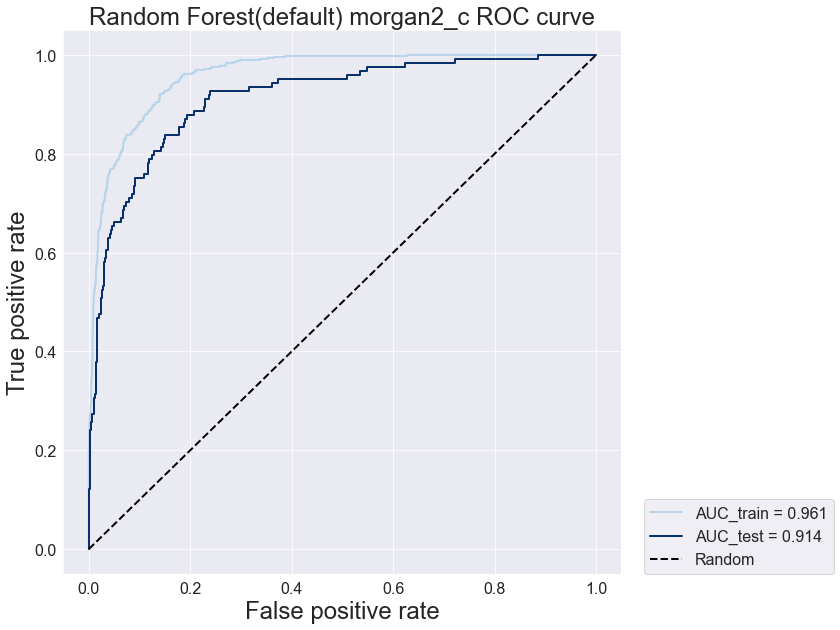

In [22]:
model_name = f'Random Forest(default) {fp_name}'
metrics_ROC_name = ['train', 'test']
plot_ROC_curve(results_ROC_default, metrics_ROC_name, model_name)

Es un caso de *overfiting*, ya que el AUC_train (área bajo la curva ROC del conjunto de entrenamiento) es 1.
Se puede deber a la cantidad de datos o a la cantidad de características.
Opciones:
1. Hacer el modelo más simple.
2. Ajustar los hyperparámetros
3. Reducir la dimensión de las características

El objetivo ahora es intentar optimizar el modelo cambiando los hiperparámetros

### Grilla de hiperparámetros Random Forest

Para encontrar el mejor modelo se hace una búsqueda de _hyper parámetros_. Se escoge la siguiente grilla, para un total de ~253400 opciones.
La búsqueda y optimización de los hiperparámetros se realiza fuera de este notebook para realizar múltiples pruebas en paralelo. El excel `results_grid_params_RFC` tiene los resultados.

### Construcción y verificación del modelo
Una vez escogidos los hypoer parámetros, se vuelve a ejecutar el modelo. Como se puede ver en las curvas ROC, se redujo el overfiting y las métricas tienen resultados positivos

#### Resultados

In [24]:
# >>> (03.23.2022): overfiting maccs - ratio:2 - n_splits:5
params_dict = {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 0.8,
'max_leaf_nodes': 40, 'oob_score': True, 'max_samples': 0.8, 'criterion': 'gini'}

Rf_clf_tuned = RandomForestClassifier(n_jobs=-1)
n_splits = 5
Rf_clf_tuned, df_results_model_tuned, results_ROC_fp = model_clf(Rf_clf_tuned, fp_name, uniprot_id,
                                                                  params_dict=params_dict, seed=seed, n_splits=n_splits,
                                                                  save_log=True, resample_factor= 0, resample_mode='over_sampling')
# print(Rf_clf_tuned.get_params())
df_results_model_tuned

Results RandomForestClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93       431
         1.0       0.86      0.55      0.67       124

    accuracy                           0.88       555
   macro avg       0.87      0.76      0.80       555
weighted avg       0.88      0.88      0.87       555



,Train,Test
Metric,,
AUC,0.961702,0.91971
accuracy,0.902208,0.879279
sensitivity_(recall),0.646465,0.646465
specificity,0.975638,0.974478
precision,0.883978,0.860759
f1_score,0.746791,0.669951
confusion_matrix,"[[1682, 42], [175, 320]]","[[420, 11], [56, 68]]"


#### ROC curve

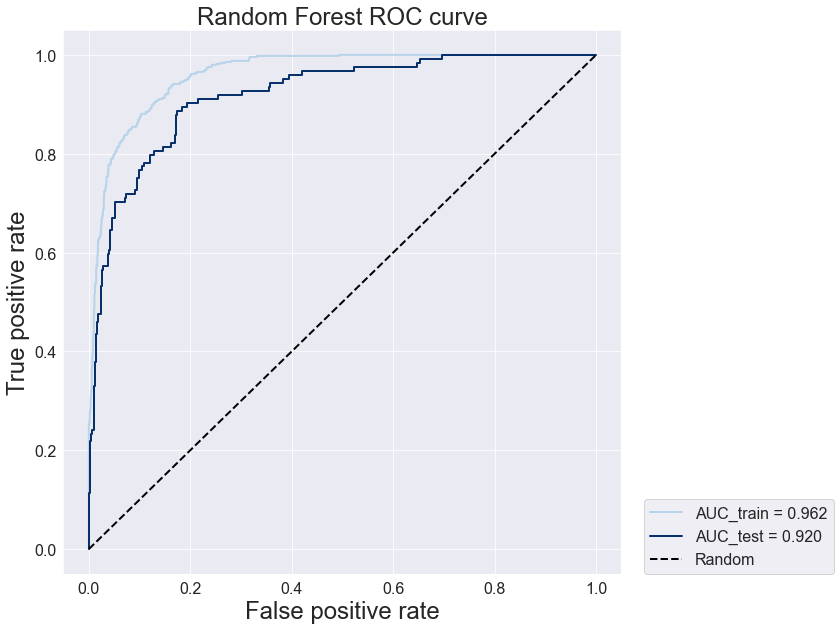

In [25]:
from lib.main_func_p4 import plot_ROC_curve

model_name = f'Random Forest'
metrics_ROC = results_ROC_fp
metrics_ROC_name = ['train', 'test']
plot_ROC_curve(metrics_ROC, metrics_ROC_name, model_name, path_file=path_file, save_fig=True)

### Curva de calibración

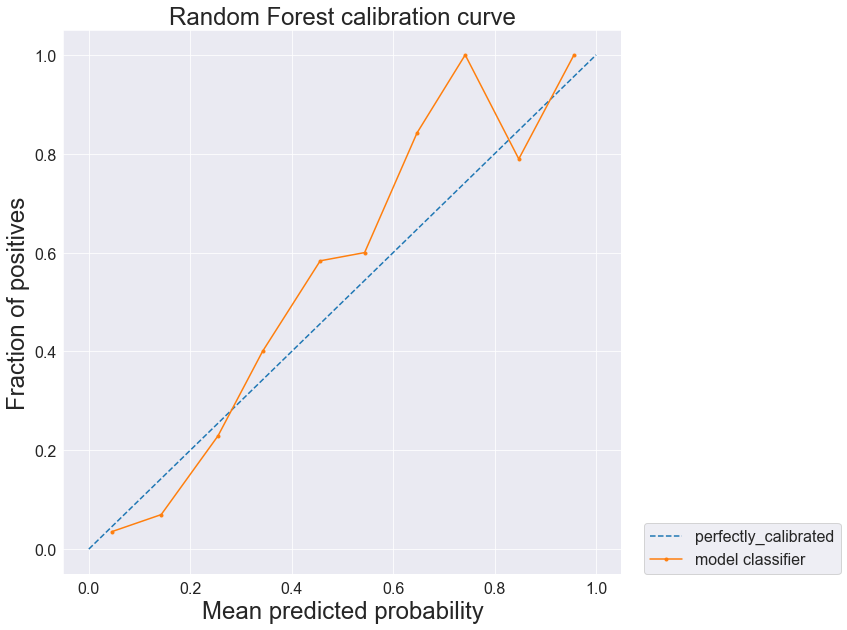

In [26]:
# Cargar conjunto de prueba
with open(f'{path_file}_dataset_test', 'rb') as f:
    df_test_calibration = pickle.load(f)
x_test = df_test_calibration[fp_name].tolist()

# Calcular probabilidades del conjunto de prueba
prob_test_calibration = Rf_clf_tuned.predict_proba(x_test)[:,1]
prob_test_calibration = np.array(prob_test_calibration)
df_test_calibration['prediction_prob'] = prob_test_calibration

# TODO: medir hyperparámetros r^2
plot_calibration_curve(df_test_calibration, model_name, path_file=path_file, save_fig=True)

### Guardar y exportar el modelo
El modelo elegido se va a exportar y a utilizar con un conjunto de decoys y el conjunto de test.

In [27]:
with open(f'{path_file}_RFclf_{fp_name}_model', 'wb') as f:
    pickle.dump(Rf_clf_tuned, f)
print(f'{uniprot_id}_RFclf_{fp_name}_model SAVED')

P49841_RFclf_morgan2_c_model SAVED


## Parte 5. Uso del modelo

### Carga del modelo
Cargar el modelo de Random Forest entrenado en el paso anterior.
Imprimir los hyper parámentros

In [28]:
with open(f'{path_file}_RFclf_{fp_name}_model', 'rb') as f:
    model_RFC = pickle.load(f)
print(f'{uniprot_id}_RFclf_{fp_name}_model LOAD')
print('Hyper parámetros : \n', model_RFC.get_params())

P49841_RFclf_morgan2_c_model LOAD
Hyper parámetros : 
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.8, 'max_leaf_nodes': 40, 'max_samples': 0.8, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_jobs': -1, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Carga del conjunto de prueba

Cargar el conjunto de prueba (el modelo no conoce los datos del conjunto de prueba).
Realizar un sub muestreo 1:1

In [29]:
with open(f'{path_file}_dataset_test', 'rb') as f:
    df_test = pickle.load(f)
print(f'Datos iniciales: {df_test.shape}')
print('Submuestreo 1:1')
# resample 1:1
df_test_active = df_test[df_test.activity == 1]
df_test_inactive = df_test[df_test.activity == 0]
n_sample = min(len(df_test_inactive), len(df_test_active))

if len(df_test_active) > len(df_test_inactive):
    df_test_active = df_test_active.sample(n_sample, random_state=seed)
elif len(df_test_inactive) > len(df_test_active):
    df_test_inactive = df_test_inactive.sample(n_sample, random_state=seed)
df_test = pd.concat([df_test_active, df_test_inactive], ignore_index=True).sample(frac=1)

df_test['type'] = 'test_inactive'
df_test.loc[df_test[df_test.activity == 1.0].index, 'type'] = 'test_active'
df_test.reset_index(drop=True, inplace=True)


df_test = df_test[['type', fp_name, 'activity']]
print(df_test.shape)
print(df_test.activity.value_counts())
df_test.head()


Datos iniciales: (490, 3)
Submuestreo 1:1
(218, 3)
1.0    109
0.0    109
Name: activity, dtype: int64


,type,morgan2_c,activity
0,test_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,test_active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


### Carga y preparación de los decoys
El archivo {uniprot_id}_all_smiles.ism contiene la lista de decoys del target.
Se carga el archivo y se convierte en un data set, por ahora solo contiene el SMILE.
Se escoge aleatoriamente una muestra con la misma cantidad de compuestos activos / inactivos (1:1:1)

In [30]:
df_decoys = pd.DataFrame(columns=['smiles'])
list_d = list()
with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
    decoys_line = f.readlines()
    for line in decoys_line[1:]: #la primera linea es header
        line = line.decode('UTF-8').split()
        list_d.append(line)
df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])

print(f'Decoys iniciales: {df_decoys.shape}')
# OPC 1: Escoger una cantidad igual al conjunto de prueba
n = int(len(df_test)/2)
df_decoys = df_decoys.sample(n=n, ignore_index=True)

# OPC 2: Trabajar con un porcentaje
# df_decoys = df_decoys.sample(frac=0.5, ignore_index=True, random_state=seed)

print(f'Decoys conjunto muestra: {len(df_decoys)}')
df_decoys.head()

Decoys iniciales: (47300, 2)
Decoys conjunto muestra: 109


,smiles,id
0,CCc1c(c(nc(n1)c2cncn2C)N)Br,C85463094
1,CC(C)c1ccc2c(c1)CCCN2C(=O)c3cc(ccc3Cl)N4CCNC4=O,C78878111
2,c1ccc(cc1)N2C[C@@H](CC2=O)NC(=O)N3CCn4cccc4[C@...,C22797922
3,Cc1cccc(c1C)Oc2c(c(=O)n3cccc(c3n2)C)/C=C(\C#N)...,C04205677
4,Cc1cc(ccc1NCc2cc(=O)n3ccsc3[nH+]2)C(=O)NC4CCCCC4,C55876707


Encontrar el fingerprint de cada compuesto a partir del SMILE.

In [31]:
from lib.main_func_p3 import calculate_onefp

calculate_onefp(df_decoys, fp_name)
df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
df_decoys.reset_index(inplace=True, drop=True)
df_decoys = df_decoys.drop(['mol'], axis=1)
df_decoys = df_decoys.drop(['smiles'], axis=1)
df_decoys['type'] = 'decoy'
df_decoys = df_decoys[['type', fp_name]]

### Predicciones

Con el modelo cargado, clasificar cada compuesto del conjunto decoys en activo: 1.0 o inactivo 0.0


In [32]:
x_decoy = df_decoys[fp_name].tolist()
pred_decoy = model_RFC.predict(x_decoy)
prediction_prob = model_RFC.predict_proba(x_decoy)[:,1]
prediction_prob = np.array(prediction_prob)
df_decoys['activity'] = 0.0
df_decoys['prediction'] = pred_decoy
df_decoys['prediction_prob'] = prediction_prob
df_decoys.head()

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.110846
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.182729
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.018294
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.066906
4,decoy,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,0.0,0.287896


Resumen de la clasificación

In [33]:
df_decoys.prediction.value_counts()

0.0    109
Name: prediction, dtype: int64

Clasificar los compuestos del conjunto de prueba. Como ya se conoce que tipo de actividad presentan, se organiza la información en varias columnas para posterior comparación.

In [34]:
x_test = df_test[fp_name].tolist()
pred_test = model_RFC.predict(x_test)
prediction_prob_test = model_RFC.predict_proba(x_test)[:,1]
prediction_prob_test = np.array(prediction_prob_test)
df_test['prediction'] = pred_test
df_test['prediction_prob'] = prediction_prob_test
df_test.head()

,type,morgan2_c,activity,prediction,prediction_prob
0,test_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0.0,0.354082
1,test_active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1.0,0.723535
2,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.041804
3,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.036906
4,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.010437


AUC score de la clasificación del conjunto de prueba

              precision    recall  f1-score   support

         0.0       0.66      0.96      0.79       109
         1.0       0.93      0.51      0.66       109

    accuracy                           0.74       218
   macro avg       0.80      0.74      0.72       218
weighted avg       0.80      0.74      0.72       218



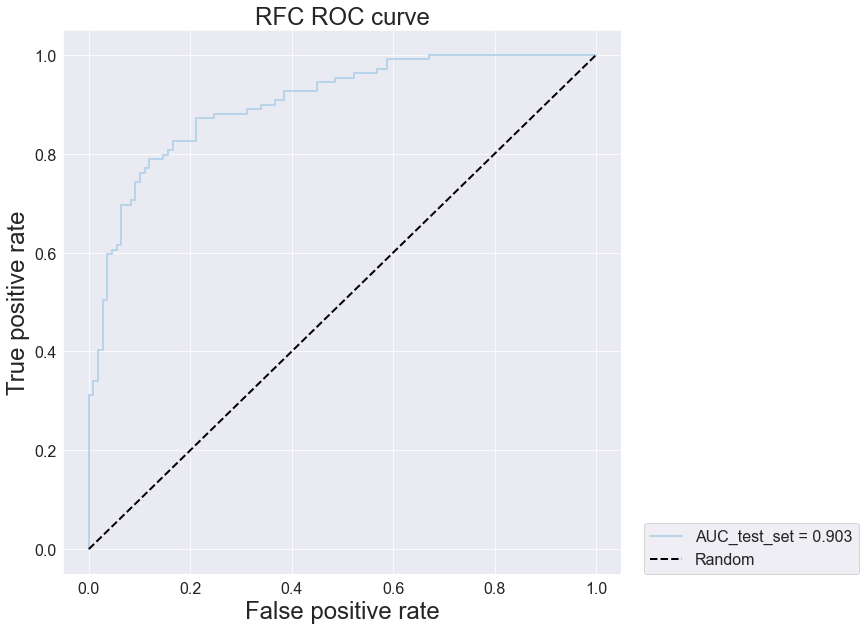

In [35]:
from lib.main_func_p4 import plot_ROC_curve
from sklearn.metrics import roc_curve, auc, classification_report
fpr_test, tpr_test, _ = roc_curve(df_test['activity'].tolist(), prediction_prob_test)
auc_score_test = auc(fpr_test, tpr_test)
metrics_ROC = (fpr_test, tpr_test, auc_score_test)
print(classification_report(df_test['activity'].tolist(), pred_test))
plot_ROC_curve([metrics_ROC], ['test_set'], 'RFC')

Concatenar los dos conjuntos de datos para visualizar el rendimiento del algoritmo de clasificación

In [36]:
df = pd.concat([df_test, df_decoys], ignore_index=True)

print(df.type.value_counts())
df.head()

test_active      109
test_inactive    109
decoy            109
Name: type, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,test_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0.0,0.354082
1,test_active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1.0,0.723535
2,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.041804
3,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.036906
4,test_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.010437


<Figure size 1080x1080 with 0 Axes>

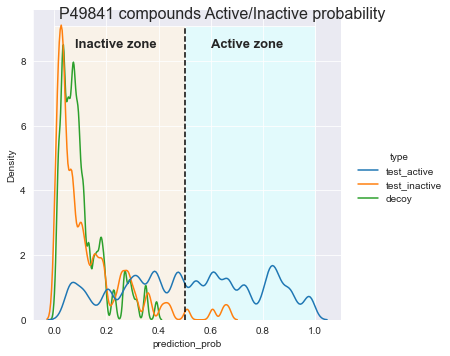

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(15,15)
ax = sns.displot(data=df, x='prediction_prob', hue="type", kind="kde", bw_adjust=.2, common_norm=False, hue_order=['test_active', 'test_inactive', 'decoy'])

plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)

plt.text(0.08, 0.88* plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88* plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.suptitle(f'{uniprot_id} compounds Active/Inactive probability',
                  fontsize=16, fontdict={"weight": "bold"})
plt.savefig(f'{path_file}_compounds_prob.png', dpi=300, bbox_inches='tight')
plt.show()

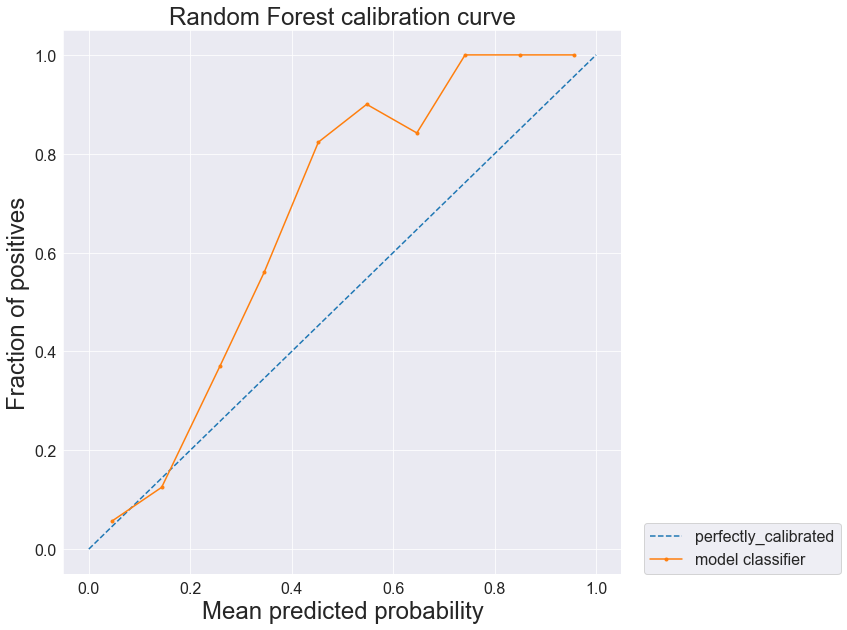

In [38]:
plot_calibration_curve(df, model_name, path_file=None, save_fig=False)

## Intermediate

In [39]:
ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_ADME_lipinski.csv')
df_int = ADME_df[ADME_df['activity_type']=='Intermediate']
df_int = df_int[['chembl_id_ligand', 'smiles']]
df_int.reset_index(drop=True, inplace=True)
print(f'No. intermediate compounds: {len(df_int)}')

No. intermediate compounds: 839


In [40]:
from lib.main_func_p3 import calculate_onefp

calculate_onefp(df_int, fp_name)
df_int.drop_duplicates(subset=['smiles'], inplace=True)
df_int.reset_index(inplace=True, drop=True)
df_int = df_int.drop(['mol'], axis=1)
df_int = df_int.drop(['smiles'], axis=1)
df_int['type'] = 'intermediate'
df_int = df_int[['type', fp_name]]
df_int.head()

,type,morgan2_c
0,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Predicciones

In [41]:
x_inter = df_int[fp_name].tolist()
pred_inter = model_RFC.predict(x_inter)
prediction_prob = model_RFC.predict_proba(x_inter)[:,1]
prediction_prob = np.array(prediction_prob)
df_int['activity'] = 0.0
df_int['prediction'] = pred_inter
df_int['prediction_prob'] = prediction_prob
df_int.prediction.value_counts()

0.0    658
1.0    181
Name: prediction, dtype: int64

<Figure size 1080x1080 with 0 Axes>

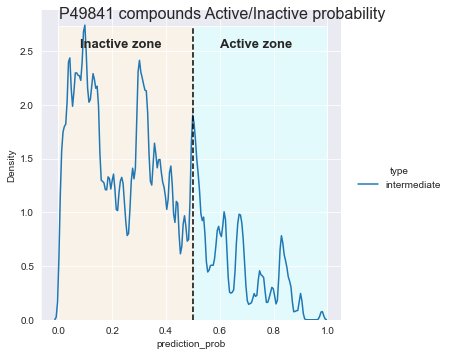

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(15,15)
ax = sns.displot(data=df_int, x='prediction_prob', hue="type", kind="kde", bw_adjust=.1, common_norm=False)

plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)

plt.text(0.08, 0.88* plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88* plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.suptitle(f'{uniprot_id} compounds Active/Inactive probability',
                  fontsize=16, fontdict={"weight": "bold"})
plt.savefig(f'{path_file}_compounds_prob.png', dpi=300, bbox_inches='tight')
plt.show()